In [1]:
import torch
import model
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [3]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


In [6]:
from dqn_agent import Agent
# Initialize an agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [7]:
# Print the agent's local network
agent.qnetwork_local

QNetwork(
  (state_value): Sequential(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (advantage): Sequential(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [8]:
# Print the agents target network
agent.qnetwork_target

QNetwork(
  (state_value): Sequential(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (advantage): Sequential(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

Episode 100	Average Score: 0.59
Episode 200	Average Score: 3.46
Episode 300	Average Score: 6.84
Episode 400	Average Score: 10.57
Episode 495	Average Score: 13.04
Environment solved in 495 episodes!	Average Score: 13.04


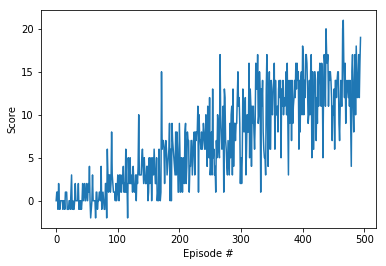

In [9]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): epsilon start for the epsilon greedy selection
        eps_end (float): end value of epsilon
        eps_decay (float): decay factor for epsilon per espisode
    """
    # Initialize the scores list
    scores = []                
    # To keep a track of the most recent 100 episodes average reward        
    scores_window = deque(maxlen=100)  
    # Initialize epsilon
    eps = eps_start     
    # Start episodes               
    for i_episode in range(1, n_episodes+1):
        # Reset env before start of each episode
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        # Initialize the score to 0 for each episode
        score = 0
        # Take steps for each episode
        for t in range(max_t):
            # take an action
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            # Add the state, action, reward and next_state after taking each action    
            reward = env_info.rewards[0]
            next_state = env_info.vector_observations[0]
            done = env_info.local_done[0]
            # Learn from the experiences 
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       
        scores.append(score)              
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # If the avg score for an episode > 13 then break since this condition is considered solving the environment.
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            # Save weights after solving the environment
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
# Save rewards plot
plt.savefig('Rewards.png')
plt.show()